In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
twitter_data = pd.read_json('tweets_msft_mod.json', orient='split')
stock_data = pd.read_json('MSFT-19.json')

In [3]:
print(twitter_data.columns)
print(len(twitter_data))
print(stock_data.columns)
print(len(stock_data))

twitter_dataMod = twitter_data.drop(twitter_data.index[[120,121,122,123,124,125,126,127]])
print(len(twitter_dataMod))

Index(['dates', 'vader_mean', 'vader_std', 'volume', 'mean_exist',
       'std_exist'],
      dtype='object')
128
Index(['APO', 'Aroon Down', 'Real Middle Band', 'MIDPOINT', 'OBV', 'SINE',
       'QUADRATURE', 'open', 'close'],
      dtype='object')
120
120


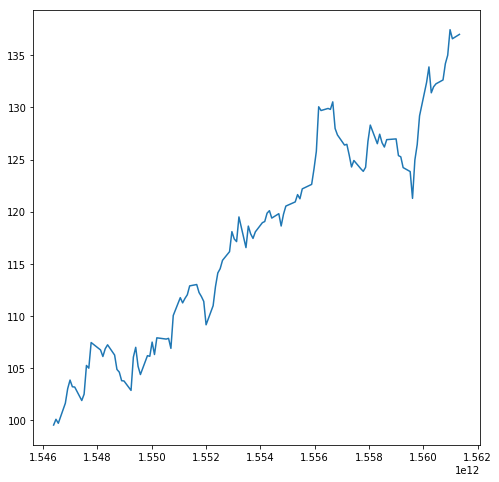

In [4]:
plt.figure(figsize=(8, 8))
plt.plot(twitter_dataMod.get('dates'), stock_data.get('open'))

In [5]:
# Shift the data to enable one-step t + 1 prediction

# Build the x and y values, note: x includes the previous opening price and closing prices
twitter_dataMod2 = twitter_dataMod.drop(twitter_dataMod.index[[0, 119]])
stock_dataMod = stock_data.drop(stock_data.index[[0, 119]]).to_numpy()
stock_dataMod2 = stock_data.drop(stock_data.index[[118, 119]]).to_numpy()

x = np.vstack((twitter_dataMod2.get('vader_mean'), twitter_dataMod2.get('vader_std'), 
              twitter_dataMod2.get('volume'), twitter_dataMod2.get('mean_exist'),
              twitter_dataMod2.get('std_exist'))).T
x2 = np.vstack((stock_dataMod[:, 0], stock_dataMod[:, 1], stock_dataMod[:, 2], 
              stock_dataMod[:, 3], stock_dataMod[:, 4], stock_dataMod[:, 5],
              stock_dataMod[:, 6], stock_dataMod2[:, 7], stock_dataMod2[:, 8])).T

x_unscaled = np.concatenate((x, x2), axis=1)
print(x.size)
print(x[0])

stock_dataMod3 = stock_data.drop(stock_data.index[[0, 1]]).to_numpy()

y_open = stock_dataMod3[:, 7].reshape(-1,1)
y_close = stock_dataMod3[:, 8].reshape(-1,1)

590
[ 0.21746429  0.45539385 28.          1.          1.        ]


In [13]:
# standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy = True, with_mean = True, with_std = True)
scaler.fit(x_unscaled)
x = (scaler.transform(x_unscaled))
# import the splitting library
from sklearn.model_selection import train_test_split

0.9699333358837307
0.964447545945314


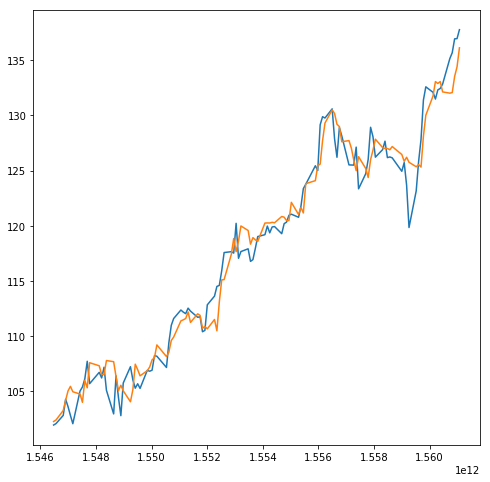

In [15]:
# basic linear regression
from sklearn import linear_model
x_train, x_test, y_train, y_test = train_test_split(x, y_close, test_size = 0.20)
reg = linear_model.LinearRegression().fit(x_train, y_train)
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
plt.figure(figsize=(8, 8))
plt.plot(twitter_dataMod2.get('dates'), y_close)
plt.plot(twitter_dataMod2.get('dates'), reg.predict(x))

10.0
0.9739390000192529
0.9391655743433067


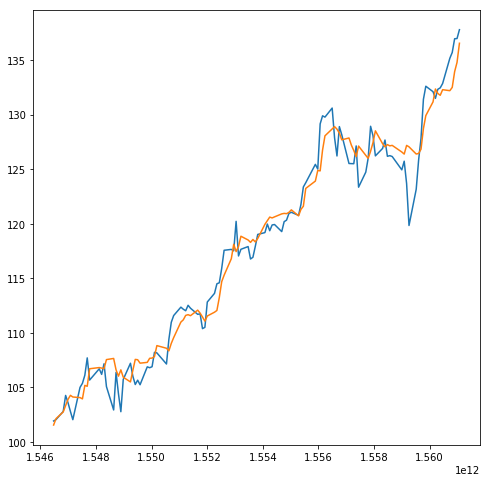

In [36]:
# ridge regression
x_train, x_test, y_train, y_test = train_test_split(x, y_close, test_size = 0.20)
reg = linear_model.RidgeCV(alphas = np.logspace(-4, 4, 9), fit_intercept = True)
reg.fit(x_train, y_train)
print(reg.alpha_)
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
plt.figure(figsize=(8, 8))
plt.plot(twitter_dataMod2.get('dates'), y_close)
plt.plot(twitter_dataMod2.get('dates'), reg.predict(x))

0.030953454951660794
0.9660621405427756
0.9697478725868501


C:\Users\patel\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\patel\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


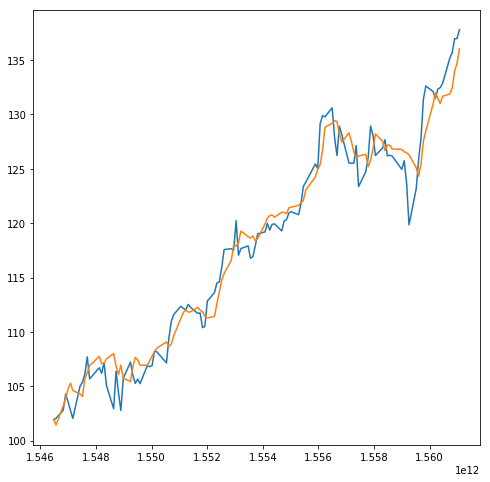

In [66]:
# lasso regression (LARS)
x_train, x_test, y_train, y_test = train_test_split(x, y_close, test_size = 0.20)
reg = linear_model.LassoLarsCV(fit_intercept = True, precompute = 'auto')

reg.fit(x_train, y_train)
print(reg.alpha_)
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
plt.figure(figsize=(8, 8))
plt.plot(twitter_dataMod2.get('dates'), y_close)
plt.plot(twitter_dataMod2.get('dates'), reg.predict(x))

0.851063829787234
0.0


C:\Users\patel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\patel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


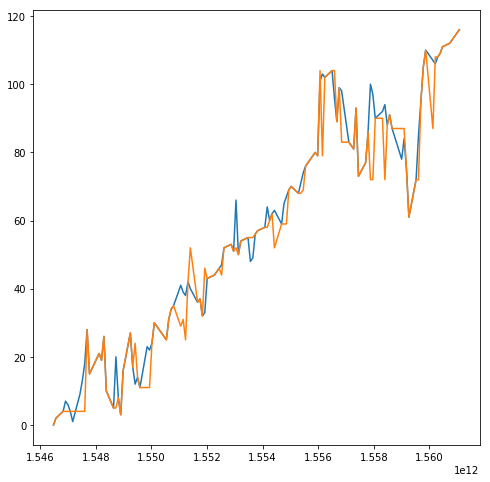

In [18]:
# Logistic regression
from sklearn import preprocessing

lab_enc = preprocessing.LabelEncoder()
encoded = lab_enc.fit_transform(np.ravel(y_close))

x_train, x_test, y_train, y_test = train_test_split(x, encoded, test_size = 0.20)
reg = linear_model.LogisticRegression().fit(x_train, np.ravel(y_train))
print(reg.score(x_train, np.ravel(y_train)))
print(reg.score(x_test, np.ravel(y_test)))
plt.figure(figsize=(8, 8))
plt.plot(twitter_dataMod2.get('dates'), encoded)
plt.plot(twitter_dataMod2.get('dates'), reg.predict(x))

0.9758855684092413
0.9396476550892747


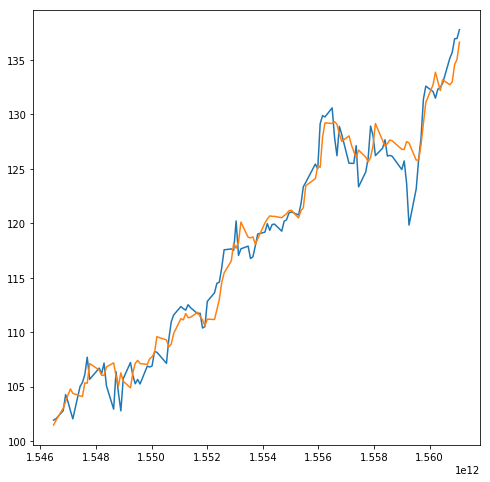

In [19]:
# Bayesian Ridge Regression
x_train, x_test, y_train, y_test = train_test_split(x, y_close, test_size = 0.20)
reg = linear_model.BayesianRidge(compute_score = True)
reg = linear_model.LinearRegression().fit(x_train, y_train)
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
plt.figure(figsize=(8, 8))
plt.plot(twitter_dataMod2.get('dates'), y_close)
plt.plot(twitter_dataMod2.get('dates'), reg.predict(x))

1.0
0.7171692067679218


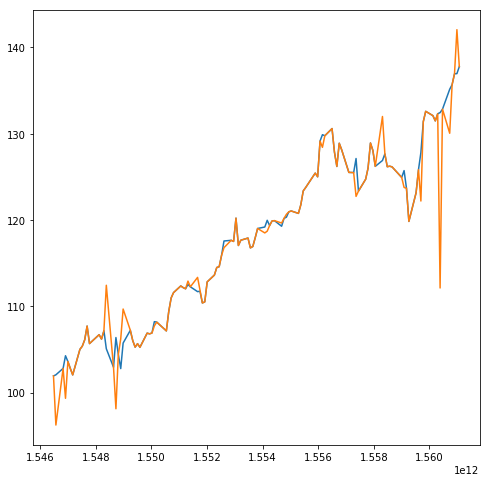

In [26]:
# Extend linear regression to polynomial 
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=4)
z = poly.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(z, y_close, test_size = 0.20)
reg = linear_model.LinearRegression().fit(x_train, y_train)
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
plt.figure(figsize=(8, 8))
plt.plot(twitter_dataMod2.get('dates'), y_close)
plt.plot(twitter_dataMod2.get('dates'), reg.predict(z))

10.0
0.9891731891292871
0.9368140577131325


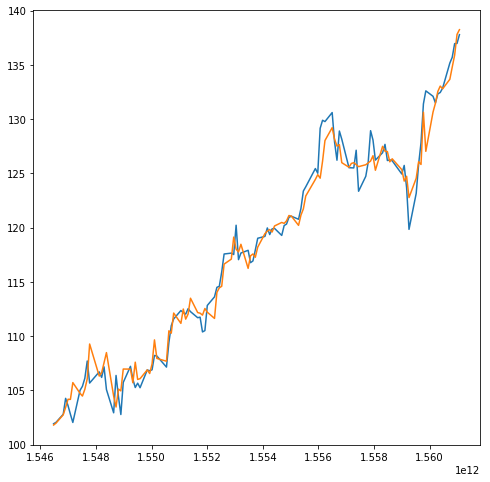

In [45]:
# Extend ridge regression to polynomial 

poly = PolynomialFeatures(degree=2)
z = poly.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(z, y_close, test_size = 0.20)
reg = linear_model.RidgeCV(alphas = np.logspace(-5, 5, 11), fit_intercept = True)
reg.fit(x_train, y_train)
print(reg.alpha_)
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
plt.figure(figsize=(8, 8))
plt.plot(twitter_dataMod2.get('dates'), y_close)
plt.plot(twitter_dataMod2.get('dates'), reg.predict(z))

0.9994046067396923
0.9279134888876686


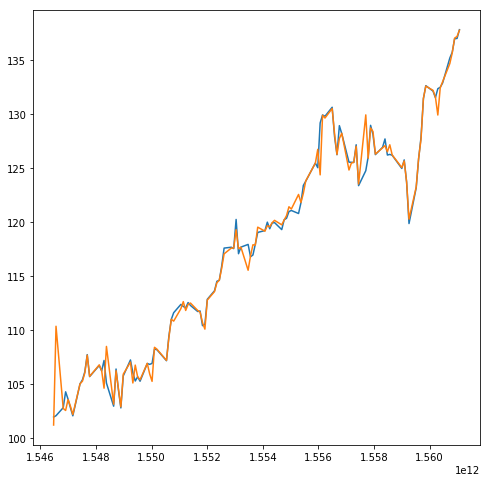

In [75]:
# Extend lasso regression to polynomial
poly = PolynomialFeatures(degree=4)
z = poly.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(z, y_close, test_size = 0.20)
reg = linear_model.LassoLars(alpha = 0.001, fit_intercept = True, precompute = 'auto',
                            fit_path = True)
reg.fit(x_train, y_train)
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
plt.figure(figsize=(8, 8))
plt.plot(twitter_dataMod2.get('dates'), y_close)
plt.plot(twitter_dataMod2.get('dates'), reg.predict(z))

C:\Users\patel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\patel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


1.0
0.0


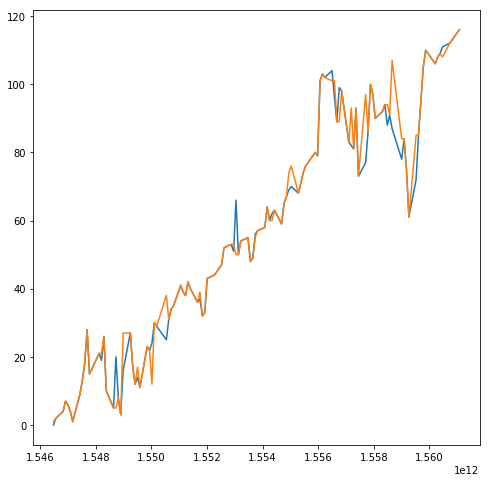

In [64]:
# extend logistic regression to polynomial
poly = PolynomialFeatures(degree=3)
z = poly.fit_transform(x)

from sklearn import preprocessing

lab_enc = preprocessing.LabelEncoder()
encoded = lab_enc.fit_transform(np.ravel(y_close))

x_train, x_test, y_train, y_test = train_test_split(z, encoded, test_size = 0.20)
reg = linear_model.LogisticRegression().fit(x_train, np.ravel(y_train))
print(reg.score(x_train, np.ravel(y_train)))
print(reg.score(x_test, np.ravel(y_test)))
plt.figure(figsize=(8, 8))
plt.plot(twitter_dataMod2.get('dates'), encoded)
plt.plot(twitter_dataMod2.get('dates'), reg.predict(z))

1.0
0.9302255498874197


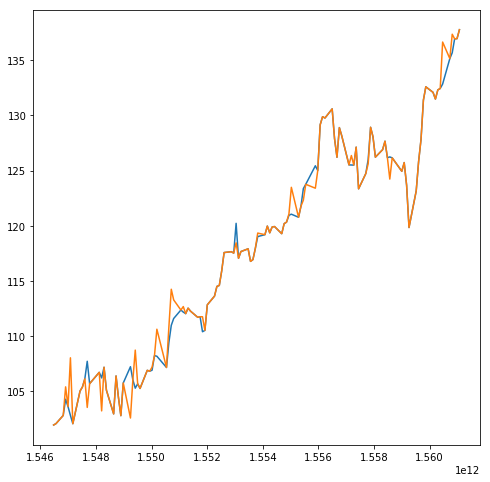

In [84]:
# extend bayesian regression to polynomial
poly = PolynomialFeatures(degree=3)
z = poly.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(z, y_close, test_size = 0.20)
reg = linear_model.BayesianRidge(compute_score = True)
reg = linear_model.LinearRegression().fit(x_train, y_train)
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
plt.figure(figsize=(8, 8))
plt.plot(twitter_dataMod2.get('dates'), y_close)
plt.plot(twitter_dataMod2.get('dates'), reg.predict(z))